In [1]:
# NumPy, Pandas, PIL, scikit-learn y Matplotlib
%pip install numpy pandas pillow scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.


In [11]:
import torch

print("Torch version:", torch.__version__)
print("CUDA compilada en Torch:", torch.version.cuda)
print("CUDA disponible?:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("Dispositivo:", torch.cuda.get_device_name(0))
    print("Número de GPUs:", torch.cuda.device_count())


Torch version: 2.5.1+cu121
CUDA compilada en Torch: 12.1
CUDA disponible?: True
Dispositivo: NVIDIA RTX 6000 Ada Generation
Número de GPUs: 1


In [2]:
%pip uninstall -y torch torchvision torchaudio

Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Successfully uninstalled torch-2.5.1+cu121
Found existing installation: torchvision 0.20.1+cu121
Uninstalling torchvision-0.20.1+cu121:
  Successfully uninstalled torchvision-0.20.1+cu121
Note: you may need to restart the kernel to use updated packages.


You can safely remove it manually.


In [3]:
%pip install torch==2.7.1 torchvision==0.22.1 torchaudio==2.7.1 --index-url https://download.pytorch.org/whl/cu128

Looking in indexes: https://download.pytorch.org/whl/cu128
  Using cached https://download.pytorch.org/whl/sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
   ---------------------------------------- 0.0/3.3 GB ? eta -:--:--
   ---------------------------------------- 0.0/3.3 GB ? eta -:--:--
   ---------------------------------------- 0.0/3.3 GB ? eta -:--:--
   ---------------------------------------- 0.0/3.3 GB 465.5 kB/s eta 1:57:12
   ---------------------------------------- 0.0/3.3 GB 465.5 kB/s eta 1:57:12
   ---------------------------------------- 0.0/3.3 GB 465.5 kB/s eta 1:57:12
   ---------------------------------------- 0.0/3.3 GB 653.6 kB/s eta 1:23:28
   ---------------------------------------- 0.0/3.3 GB 653.6 kB/s eta 1:23:28
   ---------------------------------------- 0.0/3.3 GB 653.6 kB/s eta 1:23:28
   ---------------------------------------- 0.0/3.3 GB 1.0 MB/s eta 0:53:54
   ---------------------------------------- 0.0/3.3 GB 983.0 kB/s eta 0:55:30
   --------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pip install timm pytorch-metric-learning xgboost tqdm

Note: you may need to restart the kernel to use updated packages.


In [3]:
from sklearn.metrics import f1_score

In [12]:
import os
import random
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from pytorch_metric_learning.losses import TripletMarginLoss
from pytorch_metric_learning.miners import TripletMarginMiner
from pytorch_metric_learning.samplers import MPerClassSampler

from xgboost import XGBClassifier

# ---------- Ruta a tu dataset ----------
ROOT_DIR = Path(r"C:\Users\i21315\Downloads\aver\trabajo_final_deep\Fruits Original")
assert ROOT_DIR.exists(), f"No se encontró la ruta: {ROOT_DIR}"

# ---------- Device ----------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", DEVICE)

# ---------- Semilla ----------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# ---------- Indexar el dataset ----------
def build_index(root: Path):
    registros = []
    exts = {".jpg", ".jpeg", ".png", ".bmp", ".JPG", ".JPEG", ".PNG", ".BMP"}
    
    for fruit_dir in sorted(root.iterdir()):
        if not fruit_dir.is_dir():
            continue
        fruit = fruit_dir.name  # Apple, Banana, ...

        for status_dir in sorted(fruit_dir.iterdir()):
            if not status_dir.is_dir():
                continue
            status = status_dir.name  # Fresh, Rotten, Formalin-mixed
            class_name = f"{fruit}_{status}"

            for img_path in status_dir.iterdir():
                if img_path.suffix in exts:
                    registros.append({
                        "path": str(img_path),
                        "fruit": fruit,
                        "status": status,
                        "class_name": class_name,
                    })
    return pd.DataFrame(registros)

df = build_index(ROOT_DIR)
print("Total imágenes:", len(df))
df.head()


Usando dispositivo: cuda
Total imágenes: 10154


,path,fruit,status,class_name
0,C:\Users\i21315\Downloads\aver\trabajo_final_d...,Apple,Formalin-mixed,Apple_Formalin-mixed
1,C:\Users\i21315\Downloads\aver\trabajo_final_d...,Apple,Formalin-mixed,Apple_Formalin-mixed
2,C:\Users\i21315\Downloads\aver\trabajo_final_d...,Apple,Formalin-mixed,Apple_Formalin-mixed
3,C:\Users\i21315\Downloads\aver\trabajo_final_d...,Apple,Formalin-mixed,Apple_Formalin-mixed
4,C:\Users\i21315\Downloads\aver\trabajo_final_d...,Apple,Formalin-mixed,Apple_Formalin-mixed


In [13]:
# Mapear clases a índices
class_names = sorted(df["class_name"].unique())
class_to_idx = {name: i for i, name in enumerate(class_names)}
idx_to_class = {i: name for name, i in class_to_idx.items()}

df["label"] = df["class_name"].map(class_to_idx)

num_classes = len(class_names)
print("Nº clases:", num_classes)
print(class_names)

# Split 70/15/15 estratificado
train_df, temp_df = train_test_split(
    df, test_size=0.30, stratify=df["label"], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, stratify=temp_df["label"], random_state=42
)

len(train_df), len(val_df), len(test_df)


Nº clases: 15
['Apple_Formalin-mixed', 'Apple_Fresh', 'Apple_Rotten', 'Banana_Formalin-mixed', 'Banana_Fresh', 'Banana_Rotten', 'Grape_Formalin-mixed', 'Grape_Fresh', 'Grape_Rotten', 'Mango_Formalin-mixed', 'Mango_Fresh', 'Mango_Rotten', 'Orange_Formalin-mixed', 'Orange_Fresh', 'Orange_Rotten']


(7107, 1523, 1524)

In [14]:
# ---------- Transforms (ImageNet) ----------
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_transform = T.Compose([
    T.Resize((256, 256)),
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

val_test_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])


In [15]:
# ---------- Dataset y DataLoaders básicos ----------
class FruitDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["path"]).convert("RGB")
        y = int(row["label"])
        if self.transform is not None:
            img = self.transform(img)
        return img, y

BATCH_SIZE = 32

train_dataset = FruitDataset(train_df, transform=train_transform)
val_dataset   = FruitDataset(val_df,   transform=val_test_transform)
test_dataset  = FruitDataset(test_df,  transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

len(train_dataset), len(val_dataset), len(test_dataset)


(7107, 1523, 1524)

In [16]:
def train_one_epoch(model, loader, optimizer, criterion, device, desc="Entrenando"):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for xb, yb in tqdm(loader, desc=desc, leave=False):
        xb = xb.to(device)
        yb = yb.to(device)
        
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    
    loss_epoch = running_loss / total
    acc_epoch  = correct / total
    return loss_epoch, acc_epoch


def evaluate(model, loader, criterion, device, desc="Evaluando"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for xb, yb in tqdm(loader, desc=desc, leave=False):
            xb = xb.to(device)
            yb = yb.to(device)
            
            logits = model(xb)
            loss = criterion(logits, yb)
            
            running_loss += loss.item() * xb.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    
    loss_epoch = running_loss / total
    acc_epoch  = correct / total
    return loss_epoch, acc_epoch


In [17]:
# =========================
# Experimento CNN (ResNet18)
# =========================
from copy import deepcopy

# Cargar ResNet18 preentrenada en ImageNet
cnn_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
in_features = cnn_model.fc.in_features
cnn_model.fc = nn.Linear(in_features, num_classes)  # nueva cabeza

cnn_model = cnn_model.to(DEVICE)

criterion_cnn = nn.CrossEntropyLoss()
optimizer_cnn = torch.optim.Adam(cnn_model.parameters(), lr=1e-4)

EPOCHS_CNN = 20
best_val_acc_cnn = 0.0
best_state_cnn = None
history_cnn = []

for epoch in range(1, EPOCHS_CNN + 1):
    train_loss, train_acc = train_one_epoch(
        cnn_model, train_loader, optimizer_cnn, criterion_cnn, DEVICE,
        desc=f"CNN · Época {epoch:02d} (train)"
    )
    val_loss, val_acc = evaluate(
        cnn_model, val_loader, criterion_cnn, DEVICE,
        desc=f"CNN · Época {epoch:02d} (val)"
    )
    
    history_cnn.append({
        "epoch": epoch,
        "train_loss": train_loss,
        "train_acc":  train_acc,
        "val_loss":   val_loss,
        "val_acc":    val_acc,
    })
    
    print(f"[CNN] Época {epoch:02d} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
    
    if val_acc > best_val_acc_cnn:
        best_val_acc_cnn = val_acc
        best_state_cnn = deepcopy(cnn_model.state_dict())

print("\nMejor accuracy de validación (CNN):", best_val_acc_cnn)

if best_state_cnn is not None:
    cnn_model.load_state_dict(best_state_cnn)


[CNN] Época 01 | Train Loss: 0.7197 Acc: 0.7343 | Val Loss: 0.3295 Acc: 0.8739


[CNN] Época 02 | Train Loss: 0.3923 Acc: 0.8478 | Val Loss: 0.2182 Acc: 0.9133


[CNN] Época 03 | Train Loss: 0.3156 Acc: 0.8815 | Val Loss: 0.1779 Acc: 0.9324


[CNN] Época 04 | Train Loss: 0.2783 Acc: 0.8960 | Val Loss: 0.2302 Acc: 0.9173


[CNN] Época 05 | Train Loss: 0.2352 Acc: 0.9129 | Val Loss: 0.1394 Acc: 0.9560


[CNN] Época 06 | Train Loss: 0.2246 Acc: 0.9143 | Val Loss: 0.1018 Acc: 0.9665


[CNN] Época 07 | Train Loss: 0.2109 Acc: 0.9213 | Val Loss: 0.0963 Acc: 0.9659


[CNN] Época 08 | Train Loss: 0.1819 Acc: 0.9320 | Val Loss: 0.0958 Acc: 0.9678


[CNN] Época 09 | Train Loss: 0.1562 Acc: 0.9446 | Val Loss: 0.1817 Acc: 0.9396


[CNN] Época 10 | Train Loss: 0.1589 Acc: 0.9429 | Val Loss: 0.1019 Acc: 0.9678


[CNN] Época 11 | Train Loss: 0.1502 Acc: 0.9470 | Val Loss: 0.1779 Acc: 0.9554


[CNN] Época 12 | Train Loss: 0.1543 Acc: 0.9434 | Val Loss: 0.0822 Acc: 0.9731


[CNN] Época 13 | Train Loss: 0.1348 Acc: 0.9515 | Val Loss: 0.0588 Acc: 0.9757


[CNN] Época 14 | Train Loss: 0.1400 Acc: 0.9471 | Val Loss: 0.0697 Acc: 0.9711


[CNN] Época 15 | Train Loss: 0.1421 Acc: 0.9486 | Val Loss: 0.0863 Acc: 0.9711


[CNN] Época 16 | Train Loss: 0.1383 Acc: 0.9489 | Val Loss: 0.0888 Acc: 0.9685


[CNN] Época 17 | Train Loss: 0.1187 Acc: 0.9567 | Val Loss: 0.0460 Acc: 0.9862


[CNN] Época 18 | Train Loss: 0.1092 Acc: 0.9602 | Val Loss: 0.0660 Acc: 0.9777


[CNN] Época 19 | Train Loss: 0.1145 Acc: 0.9582 | Val Loss: 0.0480 Acc: 0.9810


[CNN] Época 20 | Train Loss: 0.1094 Acc: 0.9621 | Val Loss: 0.0371 Acc: 0.9869

Mejor accuracy de validación (CNN): 0.9868680236375574


In [18]:
# ---- Evaluar CNN en test ----
cnn_model.eval()
all_preds_cnn = []
all_labels_cnn = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        logits = cnn_model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()
        
        all_preds_cnn.extend(preds)
        all_labels_cnn.extend(yb.numpy())

all_preds_cnn  = np.array(all_preds_cnn)
all_labels_cnn = np.array(all_labels_cnn)

print("=== Experimento CNN: Reporte de clasificación (TEST) ===\n")
print(classification_report(
    all_labels_cnn,
    all_preds_cnn,
    target_names=[idx_to_class[i] for i in range(num_classes)],
    digits=3
))


=== Experimento CNN: Reporte de clasificación (TEST) ===

                       precision    recall  f1-score   support

 Apple_Formalin-mixed      1.000     0.959     0.979        97
          Apple_Fresh      0.926     0.983     0.954       115
         Apple_Rotten      0.957     0.947     0.952        94
Banana_Formalin-mixed      1.000     1.000     1.000        99
         Banana_Fresh      0.982     0.991     0.987       113
        Banana_Rotten      1.000     0.968     0.984        95
 Grape_Formalin-mixed      1.000     1.000     1.000        91
          Grape_Fresh      0.959     1.000     0.979       116
         Grape_Rotten      1.000     0.947     0.973        94
 Mango_Formalin-mixed      0.989     1.000     0.995        92
          Mango_Fresh      0.991     1.000     0.996       115
         Mango_Rotten      1.000     0.968     0.984        94
Orange_Formalin-mixed      0.990     0.990     0.990        97
         Orange_Fresh      0.991     1.000     0.996       

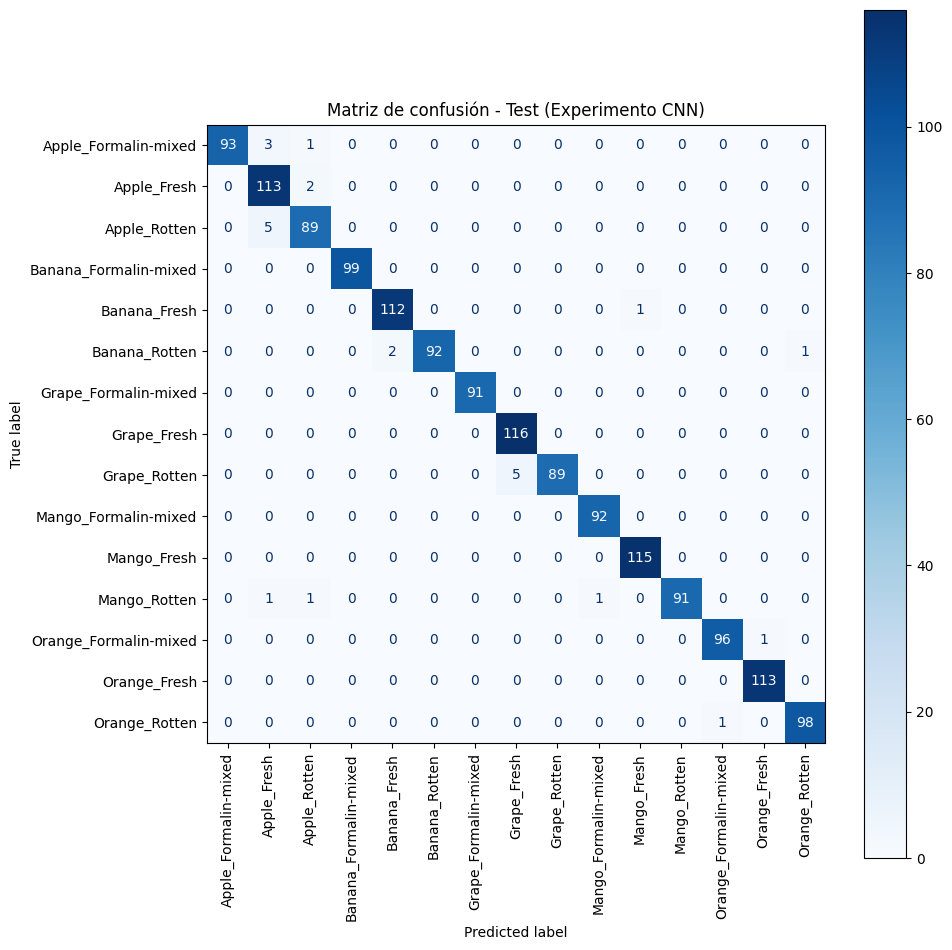

In [19]:
cm_cnn = confusion_matrix(all_labels_cnn, all_preds_cnn)
fig, ax = plt.subplots(figsize=(10, 10))
disp_cnn = ConfusionMatrixDisplay(
    confusion_matrix=cm_cnn,
    display_labels=[idx_to_class[i] for i in range(num_classes)]
)
disp_cnn.plot(xticks_rotation=90, ax=ax, cmap="Blues", colorbar=True)
plt.title("Matriz de confusión - Test (Experimento CNN)")
plt.tight_layout()
plt.show()


In [20]:
# ================================
# Bloque S1: DataLoader para siamesa
# ================================
# lista de labels para el sampler
train_labels_list = train_df["label"].tolist()
val_labels_list   = val_df["label"].tolist()

# sampler: m imágenes por clase en cada batch
M = 4
BATCH_TRIPLET = 32

train_sampler = MPerClassSampler(
    train_labels_list,
    m=M,
    batch_size=BATCH_TRIPLET,
    length_before_new_iter=len(train_labels_list)
)

val_sampler = MPerClassSampler(
    val_labels_list,
    m=M,
    batch_size=BATCH_TRIPLET,
    length_before_new_iter=len(val_labels_list)
)

siam_train_dataset = FruitDataset(train_df, transform=train_transform)
siam_val_dataset   = FruitDataset(val_df,   transform=val_test_transform)

siam_train_loader = DataLoader(
    siam_train_dataset,
    batch_size=BATCH_TRIPLET,
    sampler=train_sampler,
    num_workers=0
)

siam_val_loader = DataLoader(
    siam_val_dataset,
    batch_size=BATCH_TRIPLET,
    sampler=val_sampler,
    num_workers=0
)

len(siam_train_dataset), len(siam_val_dataset)


(7107, 1523)

In [21]:
# =========================================
# Bloque S2: Red siamesa (backbone + embed)
# =========================================
EMBED_DIM = 128

class SiameseNet(nn.Module):
    def __init__(self, embed_dim=128):
        super().__init__()
        # ResNet18 preentrenada sin capa final
        base = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        in_features = base.fc.in_features
        base.fc = nn.Identity()      # quitamos la clasificación
        
        self.backbone = base
        self.embedding = nn.Sequential(
            nn.Linear(in_features, embed_dim, bias=False),
            nn.BatchNorm1d(embed_dim),
            nn.ReLU(inplace=True),
        )
    
    def forward(self, x):
        feats = self.backbone(x)          # [B, in_features]
        emb = self.embedding(feats)       # [B, embed_dim]
        emb = F.normalize(emb, p=2, dim=1)
        return emb

siamese_net = SiameseNet(embed_dim=EMBED_DIM).to(DEVICE)
print(siamese_net)


SiameseNet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [22]:
# =========================================
# Bloque S3: Entrenar red siamesa (Triplet)
# =========================================
margin = 0.2
triplet_loss = TripletMarginLoss(margin=margin)
miner = TripletMarginMiner(margin=margin, type_of_triplets="semihard")

optimizer_siam = torch.optim.Adam(siamese_net.parameters(), lr=1e-4)
EPOCHS_TRIPLET = 10

def train_siamese_one_epoch(model, loader, optimizer, loss_fn, miner, device, desc):
    model.train()
    total_loss = 0.0
    total = 0
    
    for xb, yb in tqdm(loader, desc=desc, leave=False):
        xb = xb.to(device)
        yb = yb.to(device)
        
        optimizer.zero_grad()
        emb = model(xb)
        indices_tuple = miner(emb, yb)
        loss = loss_fn(emb, yb, indices_tuple)
        loss.backward()
        optimizer.step()
        
        bsz = xb.size(0)
        total_loss += loss.item() * bsz
        total += bsz
    
    return total_loss / total

def eval_siamese(model, loader, loss_fn, miner, device, desc):
    model.eval()
    total_loss = 0.0
    total = 0
    
    with torch.no_grad():
        for xb, yb in tqdm(loader, desc=desc, leave=False):
            xb = xb.to(device)
            yb = yb.to(device)
            
            emb = model(xb)
            indices_tuple = miner(emb, yb)
            loss = loss_fn(emb, yb, indices_tuple)
            
            bsz = xb.size(0)
            total_loss += loss.item() * bsz
            total += bsz
    
    return total_loss / total

best_val_loss_siam = float("inf")
best_state_siam = None

for epoch in range(1, EPOCHS_TRIPLET + 1):
    train_loss = train_siamese_one_epoch(
        siamese_net, siam_train_loader, optimizer_siam,
        triplet_loss, miner, DEVICE,
        desc=f"Triplet · Época {epoch:02d} (train)"
    )
    val_loss = eval_siamese(
        siamese_net, siam_val_loader,
        triplet_loss, miner, DEVICE,
        desc=f"Triplet · Época {epoch:02d} (val)"
    )
    
    print(f"[Triplet] Época {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    if val_loss < best_val_loss_siam:
        best_val_loss_siam = val_loss
        best_state_siam = deepcopy(siamese_net.state_dict())

print("\nMejor Val Triplet Loss:", best_val_loss_siam)

if best_state_siam is not None:
    siamese_net.load_state_dict(best_state_siam)


[Triplet] Época 01 | Train Loss: 0.0899 | Val Loss: 0.0944


[Triplet] Época 02 | Train Loss: 0.0895 | Val Loss: 0.0908


[Triplet] Época 03 | Train Loss: 0.0882 | Val Loss: 0.0955


[Triplet] Época 04 | Train Loss: 0.0871 | Val Loss: 0.0896


[Triplet] Época 05 | Train Loss: 0.0878 | Val Loss: 0.0984


[Triplet] Época 06 | Train Loss: 0.0861 | Val Loss: 0.0870


[Triplet] Época 07 | Train Loss: 0.0847 | Val Loss: 0.0935


[Triplet] Época 08 | Train Loss: 0.0862 | Val Loss: 0.0911


[Triplet] Época 09 | Train Loss: 0.0862 | Val Loss: 0.0886


[Triplet] Época 10 | Train Loss: 0.0828 | Val Loss: 0.0748

Mejor Val Triplet Loss: 0.07479931065376769


In [23]:
# =========================================
# Bloque S4: Clasificador FC sobre embeddings
# =========================================
class SiameseClassifier(nn.Module):
    def __init__(self, siamese_backbone, embed_dim, num_classes):
        super().__init__()
        self.siamese_backbone = siamese_backbone
        self.fc = nn.Linear(embed_dim, num_classes)
    
    def forward(self, x):
        with torch.no_grad():
            emb = self.siamese_backbone(x)
        emb = emb.detach()
        logits = self.fc(emb)
        return logits

# congelar completamente la siamesa
for p in siamese_net.parameters():
    p.requires_grad = False

model_triplet_fc = SiameseClassifier(siamese_net, EMBED_DIM, num_classes).to(DEVICE)
print(model_triplet_fc)


SiameseClassifier(
  (siamese_backbone): SiameseNet(
    (backbone): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   

In [24]:
# =========================================
# Bloque S5: Entrenamiento FC (Triplet+FC)
# =========================================
criterion_triplet_fc = nn.CrossEntropyLoss()
optimizer_triplet_fc = torch.optim.Adam(model_triplet_fc.fc.parameters(), lr=1e-3)

EPOCHS_FC = 20
best_val_acc_triplet_fc = 0.0
best_state_triplet_fc = None
history_triplet_fc = []

for epoch in range(1, EPOCHS_FC + 1):
    train_loss, train_acc = train_one_epoch(
        model_triplet_fc, train_loader, optimizer_triplet_fc,
        criterion_triplet_fc, DEVICE,
        desc=f"Triplet+FC · Época {epoch:02d} (train)"
    )
    val_loss, val_acc = evaluate(
        model_triplet_fc, val_loader, criterion_triplet_fc,
        DEVICE,
        desc=f"Triplet+FC · Época {epoch:02d} (val)"
    )
    
    history_triplet_fc.append({
        "epoch": epoch,
        "train_loss": train_loss,
        "train_acc":  train_acc,
        "val_loss":   val_loss,
        "val_acc":    val_acc,
    })
    
    print(f"[Triplet+FC] Época {epoch:02d} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
    
    if val_acc > best_val_acc_triplet_fc:
        best_val_acc_triplet_fc = val_acc
        best_state_triplet_fc = deepcopy(model_triplet_fc.state_dict())

print("\nMejor accuracy de validación (Triplet+FC):", best_val_acc_triplet_fc)

if best_state_triplet_fc is not None:
    model_triplet_fc.load_state_dict(best_state_triplet_fc)


[Triplet+FC] Época 01 | Train Loss: 2.1417 Acc: 0.7023 | Val Loss: 1.6021 Acc: 0.9028


[Triplet+FC] Época 02 | Train Loss: 1.3226 Acc: 0.8288 | Val Loss: 0.9877 Acc: 0.8982


[Triplet+FC] Época 03 | Train Loss: 0.8972 Acc: 0.8563 | Val Loss: 0.6809 Acc: 0.8956


[Triplet+FC] Época 04 | Train Loss: 0.6835 Acc: 0.8592 | Val Loss: 0.5129 Acc: 0.9009


[Triplet+FC] Época 05 | Train Loss: 0.5692 Acc: 0.8583 | Val Loss: 0.4297 Acc: 0.8982


[Triplet+FC] Época 06 | Train Loss: 0.4967 Acc: 0.8644 | Val Loss: 0.3719 Acc: 0.8963


[Triplet+FC] Época 07 | Train Loss: 0.4577 Acc: 0.8590 | Val Loss: 0.3384 Acc: 0.8969


[Triplet+FC] Época 08 | Train Loss: 0.4326 Acc: 0.8566 | Val Loss: 0.3109 Acc: 0.8995


[Triplet+FC] Época 09 | Train Loss: 0.4077 Acc: 0.8614 | Val Loss: 0.2998 Acc: 0.9054


[Triplet+FC] Época 10 | Train Loss: 0.3889 Acc: 0.8645 | Val Loss: 0.2811 Acc: 0.9028


[Triplet+FC] Época 11 | Train Loss: 0.3868 Acc: 0.8596 | Val Loss: 0.2719 Acc: 0.8982


[Triplet+FC] Época 12 | Train Loss: 0.3782 Acc: 0.8668 | Val Loss: 0.2646 Acc: 0.9002


[Triplet+FC] Época 13 | Train Loss: 0.3738 Acc: 0.8634 | Val Loss: 0.2569 Acc: 0.8982


[Triplet+FC] Época 14 | Train Loss: 0.3619 Acc: 0.8665 | Val Loss: 0.2690 Acc: 0.8923


[Triplet+FC] Época 15 | Train Loss: 0.3532 Acc: 0.8660 | Val Loss: 0.2551 Acc: 0.8969


[Triplet+FC] Época 16 | Train Loss: 0.3505 Acc: 0.8656 | Val Loss: 0.2407 Acc: 0.9035


[Triplet+FC] Época 17 | Train Loss: 0.3697 Acc: 0.8548 | Val Loss: 0.2432 Acc: 0.9015


[Triplet+FC] Época 18 | Train Loss: 0.3651 Acc: 0.8610 | Val Loss: 0.2436 Acc: 0.9048


[Triplet+FC] Época 19 | Train Loss: 0.3593 Acc: 0.8613 | Val Loss: 0.2571 Acc: 0.8923


[Triplet+FC] Época 20 | Train Loss: 0.3537 Acc: 0.8610 | Val Loss: 0.2356 Acc: 0.9054

Mejor accuracy de validación (Triplet+FC): 0.9054497701904136


In [25]:
# =========================================
# Bloque S6: Test Triplet+FC
# =========================================
model_triplet_fc.eval()
all_preds_tfc = []
all_labels_tfc = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        logits = model_triplet_fc(xb)
        preds = logits.argmax(dim=1).cpu().numpy()
        
        all_preds_tfc.extend(preds)
        all_labels_tfc.extend(yb.numpy())

all_preds_tfc  = np.array(all_preds_tfc)
all_labels_tfc = np.array(all_labels_tfc)

print("=== Experimento Triplet+FC: Reporte de clasificación (TEST) ===\n")
print(classification_report(
    all_labels_tfc,
    all_preds_tfc,
    target_names=[idx_to_class[i] for i in range(num_classes)],
    digits=3
))


=== Experimento Triplet+FC: Reporte de clasificación (TEST) ===

                       precision    recall  f1-score   support

 Apple_Formalin-mixed      0.659     0.856     0.744        97
          Apple_Fresh      0.838     0.583     0.687       115
         Apple_Rotten      0.907     0.936     0.921        94
Banana_Formalin-mixed      0.989     0.909     0.947        99
         Banana_Fresh      0.903     0.991     0.945       113
        Banana_Rotten      1.000     0.979     0.989        95
 Grape_Formalin-mixed      0.937     0.978     0.957        91
          Grape_Fresh      0.957     0.957     0.957       116
         Grape_Rotten      0.989     0.947     0.967        94
 Mango_Formalin-mixed      0.979     1.000     0.989        92
          Mango_Fresh      1.000     0.991     0.996       115
         Mango_Rotten      1.000     0.979     0.989        94
Orange_Formalin-mixed      0.736     0.691     0.713        97
         Orange_Fresh      0.730     0.814     0.770

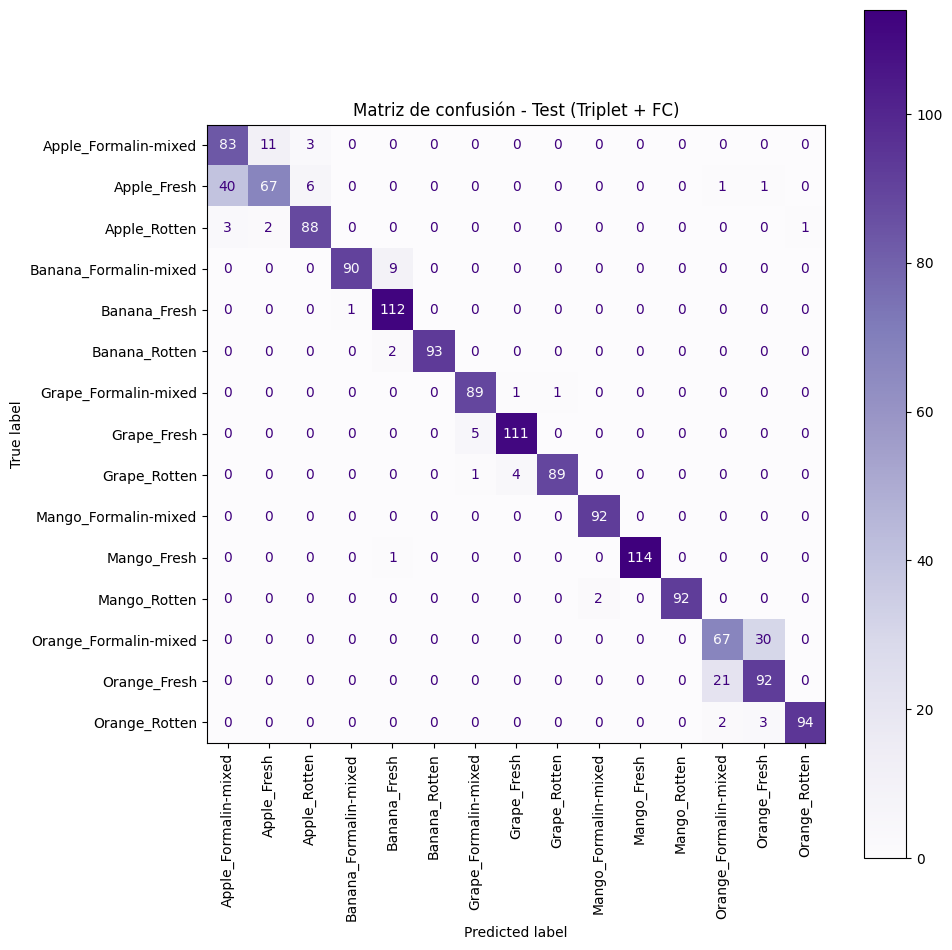

In [26]:
cm_tfc = confusion_matrix(all_labels_tfc, all_preds_tfc)
fig, ax = plt.subplots(figsize=(10, 10))
disp_tfc = ConfusionMatrixDisplay(
    confusion_matrix=cm_tfc,
    display_labels=[idx_to_class[i] for i in range(num_classes)]
)
disp_tfc.plot(xticks_rotation=90, ax=ax, cmap="Purples", colorbar=True)
plt.title("Matriz de confusión - Test (Triplet + FC)")
plt.tight_layout()
plt.show()


In [27]:
# =========================================
# Bloque X1: Extraer embeddings de cada split
# =========================================
def extract_embeddings(backbone, loader, device):
    backbone.eval()
    all_embs = []
    all_labels = []
    
    with torch.no_grad():
        for xb, yb in tqdm(loader, desc="Extrayendo embeddings", leave=False):
            xb = xb.to(device)
            emb = backbone(xb)  # salida normalizada [B, EMBED_DIM]
            all_embs.append(emb.cpu().numpy())
            all_labels.extend(yb.numpy())
    
    X = np.concatenate(all_embs, axis=0)
    y = np.array(all_labels)
    return X, y

X_train, y_train = extract_embeddings(siamese_net, train_loader, DEVICE)
X_val,   y_val   = extract_embeddings(siamese_net, val_loader,   DEVICE)
X_test,  y_test  = extract_embeddings(siamese_net, test_loader,  DEVICE)

X_train.shape, X_val.shape, X_test.shape


((7107, 128), (1523, 128), (1524, 128))

In [28]:
# =========================================
# Bloque X2: XGBoost sobre embeddings (Triplet+XGB)
# =========================================
xgb_model = XGBClassifier(
    objective="multi:softmax",
    num_class=num_classes,
    eval_metric="mlogloss",
    tree_method="hist",
    max_depth=6,
    n_estimators=300,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

y_pred_xgb = xgb_model.predict(X_test)

print("=== Experimento Triplet+XGBoost: Reporte de clasificación (TEST) ===\n")
print(classification_report(
    y_test,
    y_pred_xgb,
    target_names=[idx_to_class[i] for i in range(num_classes)],
    digits=3
))


=== Experimento Triplet+XGBoost: Reporte de clasificación (TEST) ===

                       precision    recall  f1-score   support

 Apple_Formalin-mixed      0.755     0.856     0.802        97
          Apple_Fresh      0.821     0.757     0.787       115
         Apple_Rotten      0.955     0.904     0.929        94
Banana_Formalin-mixed      0.990     0.960     0.974        99
         Banana_Fresh      0.949     0.991     0.970       113
        Banana_Rotten      1.000     0.979     0.989        95
 Grape_Formalin-mixed      0.947     0.978     0.962        91
          Grape_Fresh      0.965     0.940     0.952       116
         Grape_Rotten      0.968     0.968     0.968        94
 Mango_Formalin-mixed      0.989     1.000     0.995        92
          Mango_Fresh      1.000     1.000     1.000       115
         Mango_Rotten      1.000     0.989     0.995        94
Orange_Formalin-mixed      0.886     0.804     0.843        97
         Orange_Fresh      0.831     0.912     

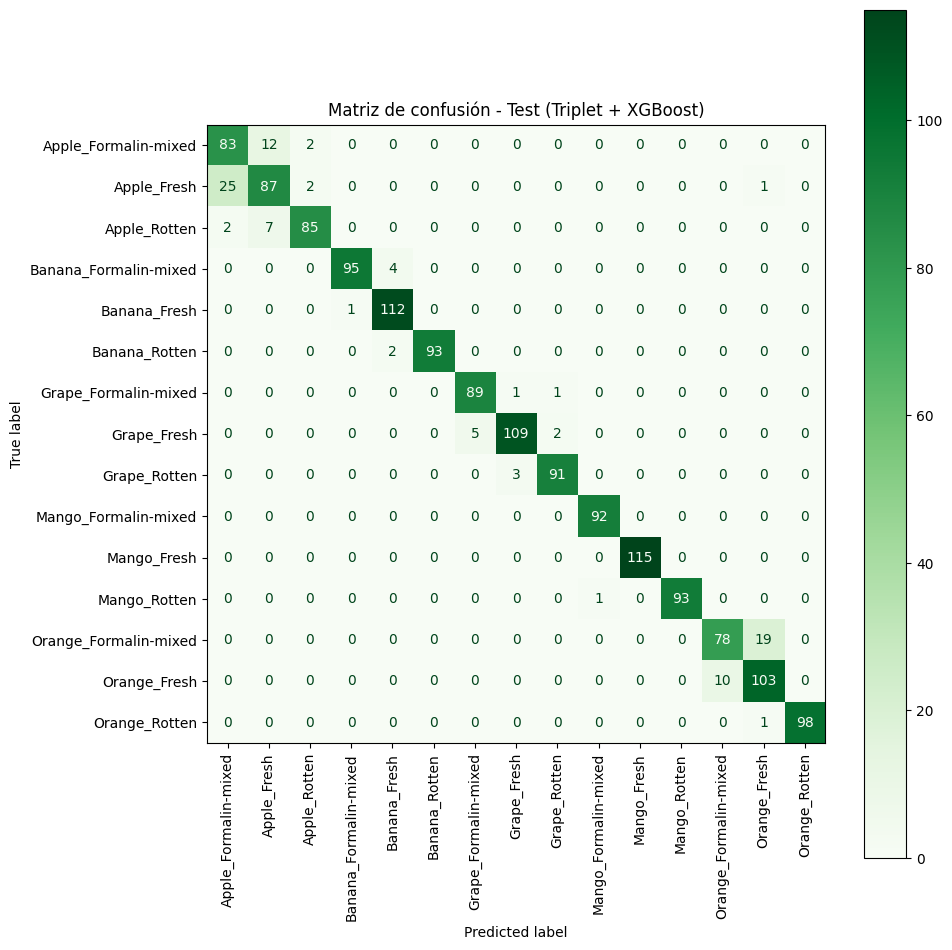

In [29]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
fig, ax = plt.subplots(figsize=(10, 10))
disp_xgb = ConfusionMatrixDisplay(
    confusion_matrix=cm_xgb,
    display_labels=[idx_to_class[i] for i in range(num_classes)]
)
disp_xgb.plot(xticks_rotation=90, ax=ax, cmap="Greens", colorbar=True)
plt.title("Matriz de confusión - Test (Triplet + XGBoost)")
plt.tight_layout()
plt.show()


# 🚀 Experimento 2: Vision Transformer (ViT)

Entrenaremos un **Vision Transformer (ViT-Base)** preentrenado en ImageNet-21k para clasificación directa.

In [7]:
from copy import deepcopy
import timm
import torch
import torch.nn as nn
from tqdm.auto import tqdm

# =========================
# Experimento 2: ViT (Vision Transformer)
# =========================

# Cargar ViT preentrenado
vit_model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)
vit_model = vit_model.to(DEVICE)

criterion_vit = nn.CrossEntropyLoss()
optimizer_vit = torch.optim.Adam(vit_model.parameters(), lr=1e-4)

EPOCHS_VIT = 20
best_val_acc_vit = 0.0
best_state_vit = None
history_vit = []

for epoch in range(1, EPOCHS_VIT + 1):
    train_loss, train_acc = train_one_epoch(
        vit_model, train_loader, optimizer_vit, criterion_vit, DEVICE,
        desc=f"ViT · Época {epoch:02d} (train)"
    )
    val_loss, val_acc = evaluate(
        vit_model, val_loader, criterion_vit, DEVICE,
        desc=f"ViT · Época {epoch:02d} (val)"
    )
    
    history_vit.append({
        "epoch": epoch,
        "train_loss": train_loss,
        "train_acc":  train_acc,
        "val_loss":   val_loss,
        "val_acc":    val_acc,
    })
    
    print(f"[ViT] Época {epoch:02d} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
    
    if val_acc > best_val_acc_vit:
        best_val_acc_vit = val_acc
        best_state_vit = deepcopy(vit_model.state_dict())

print("\nMejor accuracy de validación (ViT):", best_val_acc_vit)

if best_state_vit is not None:
    vit_model.load_state_dict(best_state_vit)

[ViT] Época 01 | Train Loss: 0.6776 Acc: 0.7352 | Val Loss: 0.3997 Acc: 0.8372


[ViT] Época 02 | Train Loss: 0.3781 Acc: 0.8479 | Val Loss: 0.2543 Acc: 0.9041


[ViT] Época 03 | Train Loss: 0.3338 Acc: 0.8718 | Val Loss: 0.2617 Acc: 0.9120


[ViT] Época 04 | Train Loss: 0.3063 Acc: 0.8796 | Val Loss: 0.2182 Acc: 0.9160


[ViT] Época 05 | Train Loss: 0.2638 Acc: 0.8973 | Val Loss: 0.1920 Acc: 0.9251


[ViT] Época 06 | Train Loss: 0.2279 Acc: 0.9118 | Val Loss: 0.1641 Acc: 0.9330


[ViT] Época 07 | Train Loss: 0.2221 Acc: 0.9118 | Val Loss: 0.1151 Acc: 0.9547


[ViT] Época 08 | Train Loss: 0.2202 Acc: 0.9150 | Val Loss: 0.2854 Acc: 0.8910


[ViT] Época 09 | Train Loss: 0.1930 Acc: 0.9274 | Val Loss: 0.1472 Acc: 0.9481


[ViT] Época 10 | Train Loss: 0.1988 Acc: 0.9233 | Val Loss: 0.1102 Acc: 0.9599


[ViT] Época 11 | Train Loss: 0.1806 Acc: 0.9306 | Val Loss: 0.1003 Acc: 0.9626


[ViT] Época 12 | Train Loss: 0.1874 Acc: 0.9312 | Val Loss: 0.1031 Acc: 0.9606


[ViT] Época 13 | Train Loss: 0.1780 Acc: 0.9308 | Val Loss: 0.1072 Acc: 0.9619


[ViT] Época 14 | Train Loss: 0.1529 Acc: 0.9453 | Val Loss: 0.1254 Acc: 0.9534


[ViT] Época 15 | Train Loss: 0.1761 Acc: 0.9343 | Val Loss: 0.0999 Acc: 0.9626


[ViT] Época 16 | Train Loss: 0.1723 Acc: 0.9358 | Val Loss: 0.1255 Acc: 0.9508


[ViT] Época 17 | Train Loss: 0.1609 Acc: 0.9403 | Val Loss: 0.0832 Acc: 0.9685


[ViT] Época 18 | Train Loss: 0.1593 Acc: 0.9406 | Val Loss: 0.1366 Acc: 0.9514


[ViT] Época 19 | Train Loss: 0.1604 Acc: 0.9409 | Val Loss: 0.2716 Acc: 0.9127


[ViT] Época 20 | Train Loss: 0.1767 Acc: 0.9350 | Val Loss: 0.1126 Acc: 0.9527

Mejor accuracy de validación (ViT): 0.9684832567301379


In [8]:
# ---- Evaluar ViT en test ----
vit_model.eval()
all_preds_vit = []
all_labels_vit = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        logits = vit_model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()
        
        all_preds_vit.extend(preds)
        all_labels_vit.extend(yb.numpy())

all_preds_vit  = np.array(all_preds_vit)
all_labels_vit = np.array(all_labels_vit)

print("=== Experimento ViT: Reporte de clasificación (TEST) ===\n")
print(classification_report(
    all_labels_vit,
    all_preds_vit,
    target_names=[idx_to_class[i] for i in range(num_classes)],
    digits=3
))

=== Experimento ViT: Reporte de clasificación (TEST) ===

                       precision    recall  f1-score   support

 Apple_Formalin-mixed      0.947     0.918     0.932        97
          Apple_Fresh      0.924     0.948     0.936       115
         Apple_Rotten      0.958     0.968     0.963        94
Banana_Formalin-mixed      1.000     1.000     1.000        99
         Banana_Fresh      0.974     1.000     0.987       113
        Banana_Rotten      1.000     0.968     0.984        95
 Grape_Formalin-mixed      0.956     0.956     0.956        91
          Grape_Fresh      0.966     0.974     0.970       116
         Grape_Rotten      0.957     0.947     0.952        94
 Mango_Formalin-mixed      0.989     0.989     0.989        92
          Mango_Fresh      1.000     0.983     0.991       115
         Mango_Rotten      0.979     0.989     0.984        94
Orange_Formalin-mixed      0.931     0.969     0.949        97
         Orange_Fresh      0.964     0.938     0.951       

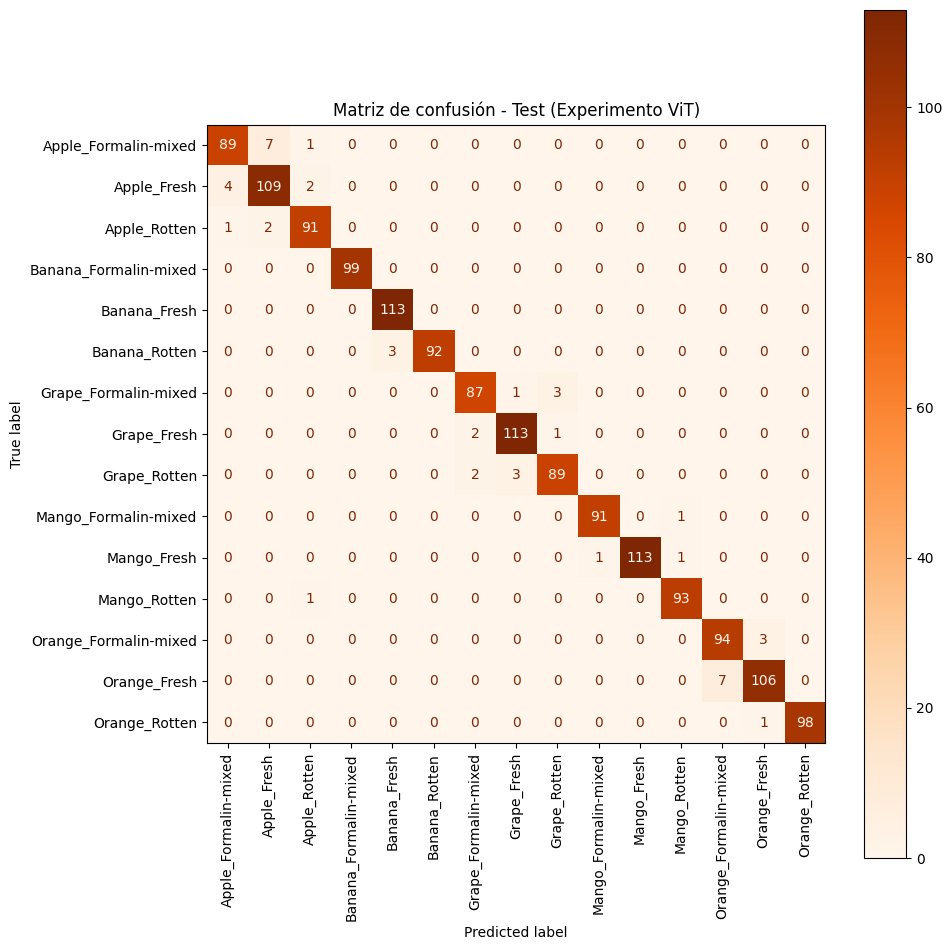

In [9]:
cm_vit = confusion_matrix(all_labels_vit, all_preds_vit)
fig, ax = plt.subplots(figsize=(10, 10))
disp_vit = ConfusionMatrixDisplay(
    confusion_matrix=cm_vit,
    display_labels=[idx_to_class[i] for i in range(num_classes)]
)
disp_vit.plot(xticks_rotation=90, ax=ax, cmap="Oranges", colorbar=True)
plt.title("Matriz de confusión - Test (Experimento ViT)")
plt.tight_layout()
plt.show()

# Experimento 3: Red Siamesa con Contrastive Loss

Entrenaremos una red siamesa usando **Contrastive Loss** para aprender embeddings discriminativos.

In [30]:
# =========================================
# Bloque C1: DataLoader para siamesa con Contrastive
# =========================================
from pytorch_metric_learning.losses import ContrastiveLoss
from pytorch_metric_learning.miners import PairMarginMiner

# Reutilizamos los datasets y samplers creados anteriormente
contrastive_train_loader = DataLoader(
    siam_train_dataset,
    batch_size=BATCH_TRIPLET,
    sampler=train_sampler,
    num_workers=0
)

contrastive_val_loader = DataLoader(
    siam_val_dataset,
    batch_size=BATCH_TRIPLET,
    sampler=val_sampler,
    num_workers=0
)

In [31]:
# =========================================
# Bloque C2: Red siamesa con Contrastive Loss
# =========================================
class SiameseNetContrastive(nn.Module):
    def __init__(self, embed_dim=128):
        super().__init__()
        # ResNet18 preentrenada sin capa final
        base = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        in_features = base.fc.in_features
        base.fc = nn.Identity()
        
        self.backbone = base
        self.embedding = nn.Sequential(
            nn.Linear(in_features, embed_dim, bias=False),
            nn.BatchNorm1d(embed_dim),
            nn.ReLU(inplace=True),
        )
    
    def forward(self, x):
        feats = self.backbone(x)
        emb = self.embedding(feats)
        emb = F.normalize(emb, p=2, dim=1)
        return emb

siamese_contrastive = SiameseNetContrastive(embed_dim=EMBED_DIM).to(DEVICE)
print(siamese_contrastive)

SiameseNetContrastive(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [32]:
# =========================================
# Bloque C3: Entrenar red siamesa (Contrastive)
# =========================================
pos_margin = 0.0
neg_margin = 1.0
contrastive_loss = ContrastiveLoss(pos_margin=pos_margin, neg_margin=neg_margin)
contrastive_miner = PairMarginMiner(pos_margin=pos_margin, neg_margin=neg_margin)

optimizer_contrastive = torch.optim.Adam(siamese_contrastive.parameters(), lr=1e-4)
EPOCHS_CONTRASTIVE = 10

def train_contrastive_one_epoch(model, loader, optimizer, loss_fn, miner, device, desc):
    model.train()
    total_loss = 0.0
    total = 0
    
    for xb, yb in tqdm(loader, desc=desc, leave=False):
        xb = xb.to(device)
        yb = yb.to(device)
        
        optimizer.zero_grad()
        emb = model(xb)
        indices_tuple = miner(emb, yb)
        loss = loss_fn(emb, yb, indices_tuple)
        loss.backward()
        optimizer.step()
        
        bsz = xb.size(0)
        total_loss += loss.item() * bsz
        total += bsz
    
    return total_loss / total

def eval_contrastive(model, loader, loss_fn, miner, device, desc):
    model.eval()
    total_loss = 0.0
    total = 0
    
    with torch.no_grad():
        for xb, yb in tqdm(loader, desc=desc, leave=False):
            xb = xb.to(device)
            yb = yb.to(device)
            
            emb = model(xb)
            indices_tuple = miner(emb, yb)
            loss = loss_fn(emb, yb, indices_tuple)
            
            bsz = xb.size(0)
            total_loss += loss.item() * bsz
            total += bsz
    
    return total_loss / total

best_val_loss_contrastive = float("inf")
best_state_contrastive = None

for epoch in range(1, EPOCHS_CONTRASTIVE + 1):
    train_loss = train_contrastive_one_epoch(
        siamese_contrastive, contrastive_train_loader, optimizer_contrastive,
        contrastive_loss, contrastive_miner, DEVICE,
        desc=f"Contrastive · Época {epoch:02d} (train)"
    )
    val_loss = eval_contrastive(
        siamese_contrastive, contrastive_val_loader,
        contrastive_loss, contrastive_miner, DEVICE,
        desc=f"Contrastive · Época {epoch:02d} (val)"
    )
    
    print(f"[Contrastive] Época {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    if val_loss < best_val_loss_contrastive:
        best_val_loss_contrastive = val_loss
        best_state_contrastive = deepcopy(siamese_contrastive.state_dict())

print("\nMejor Val Contrastive Loss:", best_val_loss_contrastive)

if best_state_contrastive is not None:
    siamese_contrastive.load_state_dict(best_state_contrastive)

[Contrastive] Época 01 | Train Loss: 1.0073 | Val Loss: 0.8284


[Contrastive] Época 02 | Train Loss: 0.8744 | Val Loss: 0.7632


[Contrastive] Época 03 | Train Loss: 0.8515 | Val Loss: 0.6880


[Contrastive] Época 04 | Train Loss: 0.8462 | Val Loss: 0.7147


[Contrastive] Época 05 | Train Loss: 0.8121 | Val Loss: 0.6732


[Contrastive] Época 06 | Train Loss: 0.8164 | Val Loss: 0.6418


[Contrastive] Época 07 | Train Loss: 0.8029 | Val Loss: 0.6584


[Contrastive] Época 08 | Train Loss: 0.7875 | Val Loss: 0.6147


[Contrastive] Época 09 | Train Loss: 0.7879 | Val Loss: 0.6125


[Contrastive] Época 10 | Train Loss: 0.7841 | Val Loss: 0.7031

Mejor Val Contrastive Loss: 0.6125096628006469


In [33]:
# =========================================
# Bloque C4: Clasificador FC sobre embeddings (Contrastive)
# =========================================
class SiameseClassifierContrastive(nn.Module):
    def __init__(self, siamese_backbone, embed_dim, num_classes):
        super().__init__()
        self.siamese_backbone = siamese_backbone
        self.fc = nn.Linear(embed_dim, num_classes)
    
    def forward(self, x):
        with torch.no_grad():
            emb = self.siamese_backbone(x)
        emb = emb.detach()
        logits = self.fc(emb)
        return logits

# congelar completamente la siamesa
for p in siamese_contrastive.parameters():
    p.requires_grad = False

model_contrastive_fc = SiameseClassifierContrastive(siamese_contrastive, EMBED_DIM, num_classes).to(DEVICE)
print(model_contrastive_fc)

SiameseClassifierContrastive(
  (siamese_backbone): SiameseNetContrastive(
    (backbone): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(

In [ ]:
# =========================================
# Bloque C5: Entrenamiento FC (Contrastive+FC)
# =========================================
criterion_contrastive_fc = nn.CrossEntropyLoss()
optimizer_contrastive_fc = torch.optim.Adam(model_contrastive_fc.fc.parameters(), lr=1e-3)

EPOCHS_FC_CONTRASTIVE = 20
best_val_acc_contrastive_fc = 0.0
best_state_contrastive_fc = None
history_contrastive_fc = []

for epoch in range(1, EPOCHS_FC_CONTRASTIVE + 1):
    train_loss, train_acc = train_one_epoch(
        model_contrastive_fc, train_loader, optimizer_contrastive_fc,
        criterion_contrastive_fc, DEVICE,
        desc=f"Contrastive+FC · Época {epoch:02d} (train)"
    )
    val_loss, val_acc = evaluate(
        model_contrastive_fc, val_loader, criterion_contrastive_fc,
        DEVICE,
        desc=f"Contrastive+FC · Época {epoch:02d} (val)"
    )
    
    history_contrastive_fc.append({
        "epoch": epoch,
        "train_loss": train_loss,
        "train_acc":  train_acc,
        "val_loss":   val_loss,
        "val_acc":    val_acc,
    })
    
    print(f"[Contrastive+FC] Época {epoch:02d} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
    
    if val_acc > best_val_acc_contrastive_fc:
        best_val_acc_contrastive_fc = val_acc
        best_state_contrastive_fc = deepcopy(model_contrastive_fc.state_dict())

print("\nMejor accuracy de validación (Contrastive+FC):", best_val_acc_contrastive_fc)

if best_state_contrastive_fc is not None:
    model_contrastive_fc.load_state_dict(best_state_contrastive_fc)

Contrastive+FC · Época 01 (train):  53%|█████▎    | 118/223 [01:30<01:16,  1.37it/s]

In [ ]:
# =========================================
# Bloque C6: Test Contrastive+FC
# =========================================
model_contrastive_fc.eval()
all_preds_cfc = []
all_labels_cfc = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        logits = model_contrastive_fc(xb)
        preds = logits.argmax(dim=1).cpu().numpy()
        
        all_preds_cfc.extend(preds)
        all_labels_cfc.extend(yb.numpy())

all_preds_cfc  = np.array(all_preds_cfc)
all_labels_cfc = np.array(all_labels_cfc)

print("=== Experimento Contrastive+FC: Reporte de clasificación (TEST) ===\n")
print(classification_report(
    all_labels_cfc,
    all_preds_cfc,
    target_names=[idx_to_class[i] for i in range(num_classes)],
    digits=3
))

In [ ]:
cm_cfc = confusion_matrix(all_labels_cfc, all_preds_cfc)
fig, ax = plt.subplots(figsize=(10, 10))
disp_cfc = ConfusionMatrixDisplay(
    confusion_matrix=cm_cfc,
    display_labels=[idx_to_class[i] for i in range(num_classes)]
)
disp_cfc.plot(xticks_rotation=90, ax=ax, cmap="Reds", colorbar=True)
plt.title("Matriz de confusión - Test (Contrastive + FC)")
plt.tight_layout()
plt.show()

In [ ]:
# =========================================
# Bloque CX1: Extraer embeddings de Contrastive
# =========================================
def extract_embeddings_contrastive(backbone, loader, device):
    backbone.eval()
    all_embs = []
    all_labels = []
    
    with torch.no_grad():
        for xb, yb in tqdm(loader, desc="Extrayendo embeddings (Contrastive)", leave=False):
            xb = xb.to(device)
            emb = backbone(xb)
            all_embs.append(emb.cpu().numpy())
            all_labels.extend(yb.numpy())
    
    X = np.concatenate(all_embs, axis=0)
    y = np.array(all_labels)
    return X, y

X_train_cont, y_train_cont = extract_embeddings_contrastive(siamese_contrastive, train_loader, DEVICE)
X_val_cont,   y_val_cont   = extract_embeddings_contrastive(siamese_contrastive, val_loader,   DEVICE)
X_test_cont,  y_test_cont  = extract_embeddings_contrastive(siamese_contrastive, test_loader,  DEVICE)

X_train_cont.shape, X_val_cont.shape, X_test_cont.shape

In [ ]:
# =========================================
# Bloque CX2: XGBoost sobre embeddings (Contrastive+XGB)
# =========================================
xgb_contrastive = XGBClassifier(
    objective="multi:softmax",
    num_class=num_classes,
    eval_metric="mlogloss",
    tree_method="hist",
    max_depth=6,
    n_estimators=300,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)

xgb_contrastive.fit(
    X_train_cont, y_train_cont,
    eval_set=[(X_val_cont, y_val_cont)],
    verbose=False
)

y_pred_xgb_cont = xgb_contrastive.predict(X_test_cont)

print("=== Experimento Contrastive+XGBoost: Reporte de clasificación (TEST) ===\n")
print(classification_report(
    y_test_cont,
    y_pred_xgb_cont,
    target_names=[idx_to_class[i] for i in range(num_classes)],
    digits=3
))

In [ ]:
cm_xgb_cont = confusion_matrix(y_test_cont, y_pred_xgb_cont)
fig, ax = plt.subplots(figsize=(10, 10))
disp_xgb_cont = ConfusionMatrixDisplay(
    confusion_matrix=cm_xgb_cont,
    display_labels=[idx_to_class[i] for i in range(num_classes)]
)
disp_xgb_cont.plot(xticks_rotation=90, ax=ax, cmap="YlGn", colorbar=True)
plt.title("Matriz de confusión - Test (Contrastive + XGBoost)")
plt.tight_layout()
plt.show()

#  Resumen Final de Experimentos

Comparación de todos los modelos entrenados.

In [ ]:
# =========================================
# Comparación de modelos en TEST
# =========================================
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Calcular métricas para cada modelo
def compute_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    return acc, prec, rec, f1

models_results = {
    "CNN (ResNet18)": compute_metrics(all_labels_cnn, all_preds_cnn),
    "ViT (Base)": compute_metrics(all_labels_vit, all_preds_vit),
    "Triplet + FC": compute_metrics(all_labels_tfc, all_preds_tfc),
    "Triplet + XGBoost": compute_metrics(y_test, y_pred_xgb),
    "Contrastive + FC": compute_metrics(all_labels_cfc, all_preds_cfc),
    "Contrastive + XGBoost": compute_metrics(y_test_cont, y_pred_xgb_cont),
}

# Crear DataFrame de resultados
results_df = pd.DataFrame(models_results, index=["Accuracy", "Precision", "Recall", "F1-Score"]).T
results_df = results_df.sort_values("Accuracy", ascending=False)

print("\n" + "="*70)
print("RESULTADOS FINALES EN TEST SET")
print("="*70)
print(results_df.to_string())
print("="*70)

NameError: name 'all_labels_cfc' is not defined

In [ ]:
# Visualización comparativa
fig, ax = plt.subplots(figsize=(12, 6))
results_df.plot(kind='bar', ax=ax, rot=45, colormap='Set2')
plt.title("Comparación de Modelos - Métricas en Test Set", fontsize=14, fontweight='bold')
plt.ylabel("Score", fontsize=12)
plt.xlabel("Modelo", fontsize=12)
plt.legend(loc='lower right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

#  Buscador de Similaridad

Sistema de búsqueda por similaridad usando los embeddings de las redes siamesas entrenadas.

In [ ]:
# =========================================
# Clase SimilaritySearcher
# =========================================
class SimilaritySearcher:
    """
    Buscador de similaridad usando embeddings de redes siamesas.
    Soporta múltiples modelos y métricas de distancia.
    """
    def __init__(self, model, device, transform, metric='cosine'):
        """
        Args:
            model: Red siamesa entrenada (SiameseNet o SiameseNetContrastive)
            device: dispositivo (cuda/cpu)
            transform: transformaciones para las imágenes
            metric: 'cosine' o 'euclidean'
        """
        self.model = model
        self.device = device
        self.transform = transform
        self.metric = metric
        self.model.eval()
        
        # Base de datos de embeddings
        self.embeddings_db = None
        self.paths_db = None
        self.labels_db = None
    
    def build_database(self, dataframe):
        """
        Construye la base de datos de embeddings para todas las imágenes.
        """
        print(f"Construyendo base de datos con {len(dataframe)} imágenes...")
        embeddings = []
        paths = []
        labels = []
        
        self.model.eval()
        with torch.no_grad():
            for idx, row in tqdm(dataframe.iterrows(), total=len(dataframe), desc="Procesando imágenes"):
                img = Image.open(row["path"]).convert("RGB")
                img_tensor = self.transform(img).unsqueeze(0).to(self.device)
                
                emb = self.model(img_tensor).cpu().numpy().flatten()
                
                embeddings.append(emb)
                paths.append(row["path"])
                labels.append(row["label"])
        
        self.embeddings_db = np.array(embeddings)
        self.paths_db = np.array(paths)
        self.labels_db = np.array(labels)
        
        print(f"Base de datos construida: {self.embeddings_db.shape}")
    
    def search(self, query_image_path, top_k=10, return_distances=True):
        """
        Busca las imágenes más similares a la imagen de consulta.
        
        Args:
            query_image_path: ruta a la imagen de consulta
            top_k: número de resultados a retornar
            return_distances: si retornar las distancias
            
        Returns:
            indices, paths, labels, [distances]
        """
        if self.embeddings_db is None:
            raise ValueError("Debe construir la base de datos primero con build_database()")
        
        # Procesar imagen de consulta
        img = Image.open(query_image_path).convert("RGB")
        img_tensor = self.transform(img).unsqueeze(0).to(self.device)
        
        self.model.eval()
        with torch.no_grad():
            query_emb = self.model(img_tensor).cpu().numpy().flatten()
        
        # Calcular distancias
        if self.metric == 'cosine':
            # Similaridad coseno (convertir a distancia: 1 - sim)
            similarities = np.dot(self.embeddings_db, query_emb)
            distances = 1 - similarities
        elif self.metric == 'euclidean':
            distances = np.linalg.norm(self.embeddings_db - query_emb, axis=1)
        else:
            raise ValueError(f"Métrica '{self.metric}' no soportada")
        
        # Obtener top-k índices (menores distancias = mayor similaridad)
        top_indices = np.argsort(distances)[:top_k]
        
        results = {
            'indices': top_indices,
            'paths': self.paths_db[top_indices],
            'labels': self.labels_db[top_indices],
        }
        
        if return_distances:
            results['distances'] = distances[top_indices]
        
        return results
    
    def visualize_results(self, query_image_path, top_k=10, figsize=(15, 8)):
        """
        Visualiza la imagen de consulta y las imágenes más similares.
        """
        results = self.search(query_image_path, top_k=top_k, return_distances=True)
        
        # Cargar imagen de consulta
        query_img = Image.open(query_image_path).convert("RGB")
        
        # Crear figura
        fig = plt.figure(figsize=figsize)
        
        # Imagen de consulta
        ax = plt.subplot(2, top_k // 2 + 1, 1)
        ax.imshow(query_img)
        ax.set_title("CONSULTA", fontsize=12, fontweight='bold', color='red')
        ax.axis('off')
        
        # Imágenes similares
        for i, (idx, path, label, dist) in enumerate(zip(
            results['indices'],
            results['paths'],
            results['labels'],
            results['distances']
        )):
            ax = plt.subplot(2, top_k // 2 + 1, i + 2)
            img = Image.open(path).convert("RGB")
            ax.imshow(img)
            class_name = idx_to_class[label]
            ax.set_title(f"#{i+1}\n{class_name}\nDist: {dist:.3f}", fontsize=9)
            ax.axis('off')
        
        plt.suptitle(f"Top {top_k} Imágenes Más Similares", fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

print("✅ Clase SimilaritySearcher definida")

In [ ]:
# =========================================
# Crear buscadores para cada modelo siamesa
# =========================================

# 1. Buscador con modelo Triplet Loss
searcher_triplet = SimilaritySearcher(
    model=siamese_net,
    device=DEVICE,
    transform=val_test_transform,
    metric='cosine'
)

# 2. Buscador con modelo Contrastive Loss
searcher_contrastive = SimilaritySearcher(
    model=siamese_contrastive,
    device=DEVICE,
    transform=val_test_transform,
    metric='cosine'
)

print("✅ Buscadores creados para ambos modelos")

In [ ]:
# =========================================
# Construir base de datos de embeddings
# =========================================
# Usamos el conjunto completo (train + val + test) para tener más imágenes en la búsqueda
df_complete = pd.concat([train_df, val_df, test_df], ignore_index=True)

print("Construyendo base de datos para Triplet Loss...")
searcher_triplet.build_database(df_complete)

print("\nConstruyendo base de datos para Contrastive Loss...")
searcher_contrastive.build_database(df_complete)

## Ejemplo 1: Búsqueda con Triplet Loss

In [ ]:
# Seleccionar una imagen de test aleatoria como consulta
sample_test = test_df.sample(1, random_state=42).iloc[0]
query_path = sample_test["path"]
query_label = sample_test["label"]

print(f"Imagen de consulta: {query_path}")
print(f"Clase real: {idx_to_class[query_label]}")
print("\n" + "="*70)

# Buscar con modelo Triplet Loss
searcher_triplet.visualize_results(query_path, top_k=10, figsize=(16, 8))

## Ejemplo 2: Búsqueda con Contrastive Loss

In [ ]:
# Usar la misma imagen de consulta
searcher_contrastive.visualize_results(query_path, top_k=10, figsize=(16, 8))

## Ejemplo 3: Comparación múltiple de búsquedas

In [ ]:
# =========================================
# Probar con diferentes clases
# =========================================
# Seleccionar una imagen de cada clase para mostrar diversidad
sample_images = []
for class_idx in range(min(3, num_classes)):  # Probar con 3 clases diferentes
    samples = test_df[test_df["label"] == class_idx]
    if len(samples) > 0:
        sample_images.append(samples.sample(1, random_state=42 + class_idx).iloc[0])

print(f"Probando búsqueda con {len(sample_images)} imágenes de diferentes clases:\n")

for i, sample in enumerate(sample_images, 1):
    query_path_demo = sample["path"]
    query_label_demo = sample["label"]
    
    print(f"\n{'='*70}")
    print(f"BÚSQUEDA {i} - Clase: {idx_to_class[query_label_demo]}")
    print(f"{'='*70}\n")
    
    # Buscar solo con Triplet (para no saturar output)
    results = searcher_triplet.search(query_path_demo, top_k=10, return_distances=True)
    
    print(f"Top 10 imágenes similares:")
    for j, (path, label, dist) in enumerate(zip(
        results['paths'][:10],
        results['labels'][:10],
        results['distances'][:10]
    ), 1):
        print(f"  {j:2d}. {idx_to_class[label]:30s} - Distancia: {dist:.4f}")
    
    # Calcular precisión (cuántas del top-10 son de la misma clase)
    same_class = sum([1 for l in results['labels'][:10] if l == query_label_demo])
    print(f"\n  ✓ Precisión Top-10: {same_class}/10 ({same_class*10:.0f}%) de la misma clase")

## Evaluación cuantitativa del buscador

Medimos la precisión promedio del sistema de búsqueda.

In [ ]:
# =========================================
# Evaluar precisión del buscador en test set
# =========================================
def evaluate_retrieval(searcher, test_dataframe, k_values=[1, 5, 10]):
    """
    Evalúa la precisión del sistema de búsqueda.
    Precision@K = proporción de imágenes relevantes en top-K
    """
    results = {k: [] for k in k_values}
    
    print(f"Evaluando con {len(test_dataframe)} imágenes de consulta...")
    
    for idx, row in tqdm(test_dataframe.iterrows(), total=len(test_dataframe), leave=False):
        query_path = row["path"]
        query_label = row["label"]
        
        # Buscar similares
        search_results = searcher.search(query_path, top_k=max(k_values), return_distances=False)
        retrieved_labels = search_results['labels']
        
        # Calcular precisión para cada K
        for k in k_values:
            # Excluir la misma imagen (primera suele ser la query)
            top_k_labels = retrieved_labels[1:k+1]  # excluir el primer resultado
            precision = sum([1 for l in top_k_labels if l == query_label]) / k
            results[k].append(precision)
    
    # Promediar
    avg_results = {k: np.mean(results[k]) for k in k_values}
    return avg_results

print("Evaluando Triplet Loss Searcher...")
metrics_triplet = evaluate_retrieval(searcher_triplet, test_df.head(50), k_values=[1, 5, 10])

print("\nEvaluando Contrastive Loss Searcher...")
metrics_contrastive = evaluate_retrieval(searcher_contrastive, test_df.head(50), k_values=[1, 5, 10])

# Mostrar resultados
print("\n" + "="*70)
print("MÉTRICAS DE RECUPERACIÓN (Precision@K)")
print("="*70)
print("\nTriplet Loss:")
for k, score in metrics_triplet.items():
    print(f"  Precision@{k:2d}: {score:.4f} ({score*100:.2f}%)")

print("\nContrastive Loss:")
for k, score in metrics_contrastive.items():
    print(f"  Precision@{k:2d}: {score:.4f} ({score*100:.2f}%)")
print("="*70)